# BaseballCV: Catcher's Glove Tracking and Analysis

In this notebook, we'll explore BaseballCV's `GloveTracker` class, a powerful tool for tracking and analyzing catcher's glove movement in baseball videos. This tracking capability allows coaches, analysts, and researchers to gain valuable insights into catcher positioning, movement patterns, and receiving techniques.

## What you'll learn:
- How to set up BaseballCV for glove tracking
- Understanding the technology behind glove tracking
- Processing individual videos for detailed analysis
- Batch processing multiple videos for comparative studies
- Scraping and analyzing MLB videos from Baseball Savant
- Interpreting glove tracking data and visualizations

Let's get started!

## 1. Environment Setup

First, let's check if we have access to a GPU, which will speed up our video processing significantly:

In [1]:
import torch

if torch.cuda.is_available():
    device_count = torch.cuda.device_count()
    device_name = torch.cuda.get_device_name(0)
    print(f"Number of CUDA devices: {device_count}")
    print(f"Device name: {device_name}")
else:
    print("CUDA is not available. Processing will be slower on CPU.")

Number of CUDA devices: 1
Device name: NVIDIA L4


Next, we'll install the necessary dependencies and clone the BaseballCV repository:

In [2]:
# Install required dependency first
!pip install git+https://github.com/Jensen-holm/statcast-era-pitches.git

# Clone the BaseballCV repository
!git clone https://github.com/dylandru/BaseballCV.git

  Cloning https://github.com/Jensen-holm/statcast-era-pitches.git to /tmp/pip-req-build-47bu0_3b
  Running command git clone --filter=blob:none --quiet https://github.com/Jensen-holm/statcast-era-pitches.git /tmp/pip-req-build-47bu0_3b
  Resolved https://github.com/Jensen-holm/statcast-era-pitches.git to commit 1532fe62d91a21028137bb60baa587ec6fd55854
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for statcast_pitches: filename=statcast_pitches-1.0.0-py3-none-any.whl size=4397 sha256=80df6d224d7f7846566967698071d2d4acd35b64a5ea465ae3efd0644aa83ded
  Stored in directory: /tmp/pip-ephem-wheel-cache-nc4yprkb/wheels/22/b2/d0/a0ec195fa1805ed1149117ae92660515ef7d531942b29f2ac0
Successfully built statcast_pitches
Cloning into 'BaseballCV'...
remote: Enumerating objects: 4370, done.
remote: Counting objects: 100% (523/523), done.
remote: Compressing objects: 100% (372/372), done.
remote: Tot

Now let's navigate to the repository directory and install it in development mode:

In [3]:
%cd BaseballCV
!pip install -e .

/content/BaseballCV
Obtaining file:///content/BaseballCV
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 15.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached ninja-1.11.1.4-py3-none-manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata (5.0 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━

We also need to install YOLOv9, which is the object detection model used by the glove tracker:

In [1]:
!pip install -q git+https://github.com/dylandru/yolov9.git

  Preparing metadata (setup.py) ... done


Now we're ready to import the necessary libraries:

In [2]:
import os
import time
import torch
from google.colab import files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
import glob
from baseballcv.functions import BaseballTools

ERROR:BaseballCV - Git Dependency Installer:Failed to install git+https://github.com/Jensen-holm/statcast-era-pitches.git@1.1: check_and_install() takes 0 positional arguments but 1 was given


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


Importing from timm.models.layers is deprecated, please import via timm.layers


## 2. Understanding Glove Tracking

The `GloveTracker` class uses computer vision and deep learning to track three key elements in baseball videos:

1. **Catcher's glove** - Tracks the position and movement of the catcher's mitt
2. **Home plate** - Serves as a reference point for coordinate transformation
3. **Baseball** - Tracks the ball to analyze pitch location relative to the glove

### How the technology works:

1. **Object Detection**: The tracker uses YOLOv9 (You Only Look Once) models to detect objects in each frame.

2. **Coordinate Transformation**: It converts pixel coordinates to real-world measurements (inches) using home plate as a reference (a standard home plate is 17 inches wide).

3. **Outlier Filtering**: The tracker applies velocity-based filtering to remove physically impossible movements, ensuring smooth and realistic tracking.

4. **Visualization**: It generates tracking plots, heatmaps, and annotated videos to help visualize glove positioning patterns.

### Key applications:

- Analyzing catcher receiving techniques
- Studying target presentation and pitch framing
- Evaluating catcher positioning and movement patterns
- Identifying patterns in glove positioning for different pitch types or situations

## 3. Initializing the Glove Tracker

The `GloveTracker` is accessed through the `BaseballTools` class. Let's initialize it:

In [3]:
# Initialize BaseballTools with the appropriate device (GPU if available)
baseball_tools = BaseballTools(device='cuda' if torch.cuda.is_available() else 'cpu')

## 4. Single Video Analysis

Let's process a single video to understand the basic functionality. First, we'll upload a video file:

Please upload a baseball video file for analysis:


Saving AJ-curveball.mp4 to AJ-curveball.mp4
2025-04-11 21:59:57,003 - LoadTools - INFO - Model downloaded to models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


INFO:LoadTools:Model downloaded to models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


2025-04-11 21:59:57,196 - BaseballTools - INFO - Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


INFO:BaseballTools:Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


2025-04-11 21:59:57,197 - BaseballTools - INFO - Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


INFO:BaseballTools:Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


2025-04-11 21:59:59,138 - BaseballTools - INFO - Home plate reference set: 4.94 pixels per inch


INFO:BaseballTools:Home plate reference set: 4.94 pixels per inch


2025-04-11 21:59:59,165 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:01:32,892 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_AJ-curveball_tracking.csv with 474 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_AJ-curveball_tracking.csv with 474 frames


2025-04-11 22:01:32,893 - BaseballTools - INFO - Processed coordinates: 474 frames, Interpolated: 76 frames


INFO:BaseballTools:Processed coordinates: 474 frames, Interpolated: 76 frames


2025-04-11 22:01:32,895 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_AJ-curveball_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_AJ-curveball_tracking.csv


2025-04-11 22:01:32,896 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_AJ-curveball.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_AJ-curveball.mp4


2025-04-11 22:01:32,896 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_AJ-curveball_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_AJ-curveball_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:01:33,387 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_AJ-curveball.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_AJ-curveball.png


2025-04-11 22:01:33,388 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_AJ-curveball.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_AJ-curveball.png


Output video saved to: glove_tracking_results/tracked_AJ-curveball.mp4
Tracking data saved to: glove_tracking_results/tracked_AJ-curveball_tracking.csv
Heatmap saved to: glove_tracking_results/glove_heatmap_AJ-curveball.png


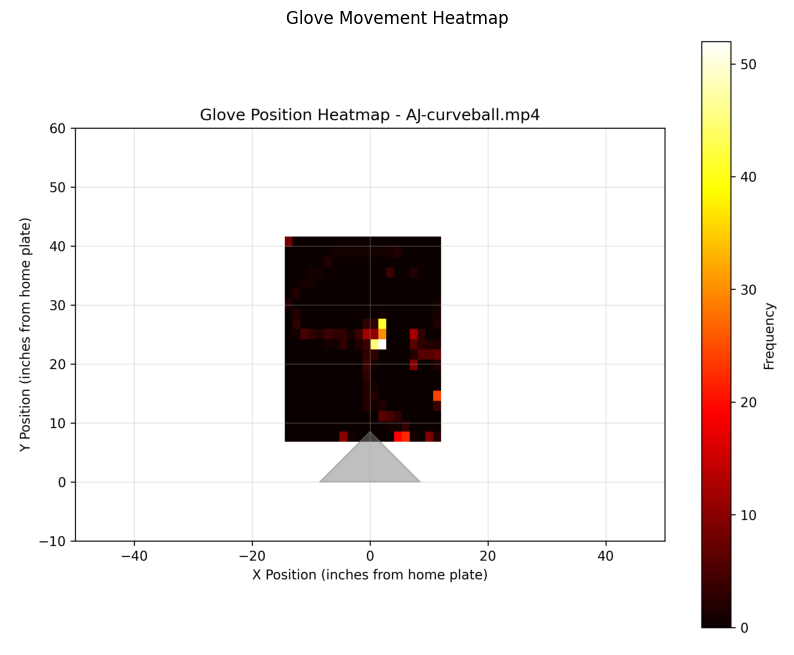


Glove Movement Analysis:
  total_frames: 474
  frames_with_glove: 398
  frames_with_baseball: 136
  frames_with_homeplate: 474
  total_distance_inches: 283.57
  max_distance_between_frames_inches: 39.26
  avg_distance_between_frames_inches: 0.71
  convex_hull_area_sq_inches: 676.10
  x_range_inches: 26.51
  y_range_inches: 34.81
  avg_x_position_inches: 1.86
  avg_y_position_inches: 22.79


In [4]:
# Upload a video file
print("Please upload a baseball video file for analysis:")
uploaded = files.upload()
video_filename = list(uploaded.keys())[0]

# Process the video
result = baseball_tools.track_gloves(
    mode="regular",                  # Process a single video
    video_path=video_filename,       # Path to the uploaded video
    confidence_threshold=0.25,       # Minimum confidence for detections
    enable_filtering=True,           # Filter out physically impossible movements
    max_velocity_inches_per_sec=120.0, # Maximum plausible glove velocity (inches/sec)
    show_plot=True,                  # Include 2D tracking plot in output video
    generate_heatmap=True,           # Generate a heatmap of glove positions
    create_video=True                # Create an annotated output video
)

print(f"Output video saved to: {result['output_video']}")
print(f"Tracking data saved to: {result['tracking_data']}")

# Display the heatmap if available
if 'heatmap' in result and result['heatmap']:
    print(f"Heatmap saved to: {result['heatmap']}")

    # Display the heatmap image
    try:
        heatmap_img = cv2.imread(result['heatmap'])
        if heatmap_img is not None:
            heatmap_img_rgb = cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 8))
            plt.imshow(heatmap_img_rgb)
            plt.axis('off')
            plt.title("Glove Movement Heatmap")
            plt.show()
    except Exception as e:
        print(f"Note: Could not display heatmap image: {e}")

# Display movement statistics
if 'movement_stats' in result and result['movement_stats']:
    print("\nGlove Movement Analysis:")
    for key, value in result['movement_stats'].items():
        if isinstance(value, float):
            print(f"  {key}: {value:.2f}")
        else:
            print(f"  {key}: {value}")

### Understanding the output:

When the glove tracker processes a video, it produces several outputs:

1. **Annotated Video**: Shows the detected objects with bounding boxes and real-world coordinates.

2. **Tracking Data (CSV)**: Contains frame-by-frame data with:
   - Pixel coordinates of detected objects
   - Real-world coordinates (inches) relative to home plate
   - Detection confidence scores
   - Flags for interpolated vs. actual detections

3. **Heatmap**: Visualizes the distribution of glove positions throughout the video.

4. **Movement Statistics**: Quantitative metrics about glove movement:
   - Total distance traveled
   - Range of motion in X and Y directions
   - Average position
   - Maximum and average movement between frames

## 5. Understanding the Tracking Data

Let's examine the tracking data CSV to understand what information is available:


Sample of tracking data:


,frame_idx,homeplate_center_x,homeplate_center_y,homeplate_width,homeplate_confidence,glove_center_x,glove_center_y,glove_confidence,glove_real_x,glove_real_y,baseball_center_x,baseball_center_y,baseball_confidence,baseball_real_x,baseball_real_y,pixels_per_inch,glove_processed_x,glove_processed_y,is_interpolated,video_filename
0,0,651.0,428.0,84,0.464756,658.5,312.0,0.789638,1.517857,23.47619,NaN,NaN,NaN,NaN,NaN,4.941176,1.517857,23.47619,False,AJ-curveball.mp4
1,1,651.0,428.0,84,0.464252,658.5,312.0,0.790016,1.517857,23.47619,NaN,NaN,NaN,NaN,NaN,4.941176,1.517857,23.47619,False,AJ-curveball.mp4
2,2,651.0,428.0,84,0.464116,658.5,312.0,0.791291,1.517857,23.47619,NaN,NaN,NaN,NaN,NaN,4.941176,1.517857,23.47619,False,AJ-curveball.mp4
3,3,651.0,428.0,84,0.466323,658.5,312.0,0.786613,1.517857,23.47619,NaN,NaN,NaN,NaN,NaN,4.941176,1.517857,23.47619,False,AJ-curveball.mp4
4,4,651.5,428.0,83,0.467340,658.5,312.0,0.787324,1.517857,23.47619,NaN,NaN,NaN,NaN,NaN,4.941176,1.517857,23.47619,False,AJ-curveball.mp4



Tracking data columns:
  frame_idx
  homeplate_center_x
  homeplate_center_y
  homeplate_width
  homeplate_confidence
  glove_center_x
  glove_center_y
  glove_confidence
  glove_real_x
  glove_real_y
  baseball_center_x
  baseball_center_y
  baseball_confidence
  baseball_real_x
  baseball_real_y
  pixels_per_inch
  glove_processed_x
  glove_processed_y
  is_interpolated
  video_filename

Glove position summary statistics (inches from home plate):


,glove_real_x,glove_real_y
count,398.000000,398.000000
mean,1.859057,22.790485
std,5.357446,6.658562
min,-14.470238,6.779762
25%,0.708333,22.084821
50%,1.517857,23.779762
75%,4.148810,25.272321
max,12.041667,41.589286


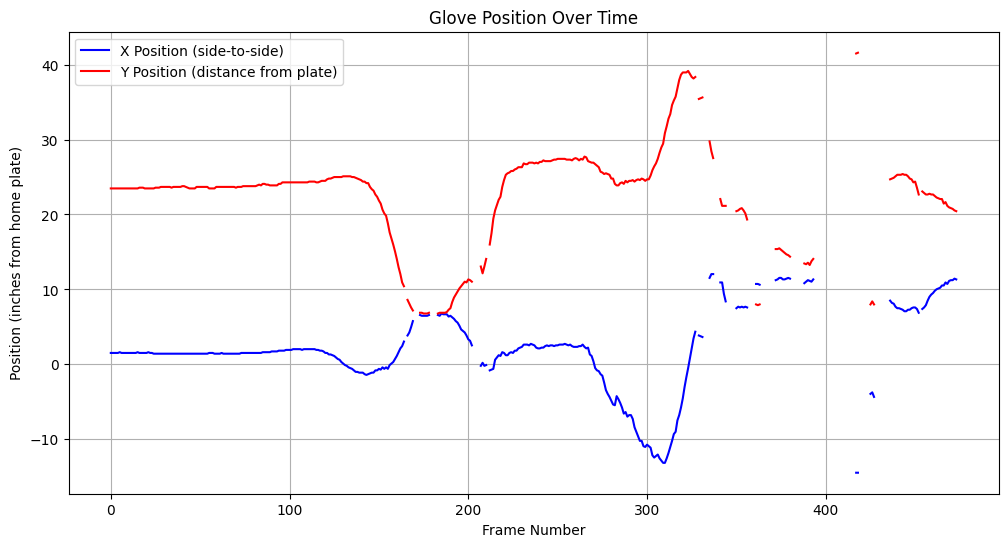

In [5]:
# Load the tracking data CSV
if 'tracking_data' in result:
    tracking_df = pd.read_csv(result['tracking_data'])

    # Display the first few rows
    print("\nSample of tracking data:")
    display(tracking_df.head())

    # Show information about the columns
    print("\nTracking data columns:")
    for column in tracking_df.columns:
        print(f"  {column}")

    # Summary statistics for glove position
    print("\nGlove position summary statistics (inches from home plate):")
    stats = tracking_df[['glove_real_x', 'glove_real_y']].describe()
    display(stats)

    # Plot glove position over time
    plt.figure(figsize=(12, 6))
    plt.plot(tracking_df['frame_idx'], tracking_df['glove_real_x'], 'b-', label='X Position (side-to-side)')
    plt.plot(tracking_df['frame_idx'], tracking_df['glove_real_y'], 'r-', label='Y Position (distance from plate)')
    plt.xlabel('Frame Number')
    plt.ylabel('Position (inches from home plate)')
    plt.title('Glove Position Over Time')
    plt.legend()
    plt.grid(True)
    plt.show()

### Key fields in the tracking data:

- **Frame information**: `frame_idx`
- **Home plate data**: `homeplate_center_x`, `homeplate_center_y`, `homeplate_width`, `homeplate_confidence`
- **Glove data**:
  - Pixel coordinates: `glove_center_x`, `glove_center_y`
  - Real-world coordinates: `glove_real_x`, `glove_real_y` (inches from home plate)
  - Processed coordinates: `glove_processed_x`, `glove_processed_y` (filtered and smoothed)
- **Baseball data**: Similar fields for ball position
- **Metadata**: `pixels_per_inch`, `is_interpolated`

The real-world coordinate system is centered on home plate with:
- X-axis: Side-to-side position (negative = inside to right-handed batter)
- Y-axis: Distance from plate (positive = farther from plate)

## 6. Batch Video Processing

Now let's try processing multiple videos to compare glove movements across different clips:


Please upload videos for batch analysis (you can select multiple files):


Saving WW-curveball.mp4 to WW-curveball.mp4
Saving test-fs.mp4 to test-fs.mp4
Saving test-sinker.mp4 to test-sinker.mp4
Saved WW-curveball.mp4 to batch_videos
Saved test-fs.mp4 to batch_videos
Saved test-sinker.mp4 to batch_videos

Found 3 videos in the batch directory
2025-04-11 22:04:32,661 - LoadTools - INFO - Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


INFO:LoadTools:Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


2025-04-11 22:04:32,817 - BaseballTools - INFO - Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


INFO:BaseballTools:Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


2025-04-11 22:04:32,819 - BaseballTools - INFO - Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


INFO:BaseballTools:Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


2025-04-11 22:04:32,821 - BaseballTools - INFO - Found 3 videos to process in batch_videos


INFO:BaseballTools:Found 3 videos to process in batch_videos


2025-04-11 22:04:32,823 - BaseballTools - INFO - Processing videos sequentially


INFO:BaseballTools:Processing videos sequentially
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2025-04-11 22:04:36,846 - BaseballTools - INFO - Home plate reference set: 4.12 pixels per inch


INFO:BaseballTools:Home plate reference set: 4.12 pixels per inch


2025-04-11 22:04:36,856 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,051 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,236 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,410 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,580 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,754 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:37,929 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:38,099 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:38,273 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:04:38,445 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:06:10,180 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_WW-curveball_tracking.csv with 492 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_WW-curveball_tracking.csv with 492 frames


2025-04-11 22:06:10,181 - BaseballTools - INFO - Processed coordinates: 424 frames, Interpolated: 113 frames


INFO:BaseballTools:Processed coordinates: 424 frames, Interpolated: 113 frames


2025-04-11 22:06:10,183 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_WW-curveball_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_WW-curveball_tracking.csv


2025-04-11 22:06:10,184 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_WW-curveball.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_WW-curveball.mp4


2025-04-11 22:06:10,184 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_WW-curveball_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_WW-curveball_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:06:10,629 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_WW-curveball.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_WW-curveball.png


2025-04-11 22:06:10,630 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_WW-curveball.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_WW-curveball.png
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2025-04-11 22:06:17,114 - BaseballTools - INFO - Home plate reference set: 4.82 pixels per inch


INFO:BaseballTools:Home plate reference set: 4.82 pixels per inch


2025-04-11 22:06:17,124 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:23,705 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_test-sinker_tracking.csv with 376 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_test-sinker_tracking.csv with 376 frames


2025-04-11 22:07:23,706 - BaseballTools - INFO - Processed coordinates: 319 frames, Interpolated: 61 frames


INFO:BaseballTools:Processed coordinates: 319 frames, Interpolated: 61 frames


2025-04-11 22:07:23,707 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_test-sinker_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_test-sinker_tracking.csv


2025-04-11 22:07:23,708 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_test-sinker.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_test-sinker.mp4


2025-04-11 22:07:23,709 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_test-sinker_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_test-sinker_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:07:24,164 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_test-sinker.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_test-sinker.png


2025-04-11 22:07:24,165 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_test-sinker.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_test-sinker.png


2025-04-11 22:07:24,238 - BaseballTools - WARNING - No valid glove detection sequences found


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2025-04-11 22:07:24,409 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:24,585 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:24,746 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:24,911 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:25,075 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:25,241 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:25,410 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:25,574 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:07:25,729 - BaseballTools - INFO - Home plate reference set: 4.00 pixels per inch


INFO:BaseballTools:Home plate reference set: 4.00 pixels per inch


2025-04-11 22:07:25,738 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:08:50,568 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_test-fs_tracking.csv with 436 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_test-fs_tracking.csv with 436 frames


2025-04-11 22:08:50,569 - BaseballTools - INFO - Processed coordinates: 358 frames, Interpolated: 41 frames


INFO:BaseballTools:Processed coordinates: 358 frames, Interpolated: 41 frames


2025-04-11 22:08:50,570 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_test-fs_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_test-fs_tracking.csv


2025-04-11 22:08:50,572 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_test-fs.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_test-fs.mp4


2025-04-11 22:08:50,573 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_test-fs_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_test-fs_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:08:51,034 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_test-fs.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_test-fs.png


2025-04-11 22:08:51,035 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_test-fs.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_test-fs.png


2025-04-11 22:08:51,058 - BaseballTools - INFO - Combined tracking data saved to glove_tracking_results/batch_tracking_results_20250411-220851.csv


INFO:BaseballTools:Combined tracking data saved to glove_tracking_results/batch_tracking_results_20250411-220851.csv


2025-04-11 22:08:51,068 - BaseballTools - INFO - Batch summary saved to glove_tracking_results/batch_summary_20250411-220851.csv


INFO:BaseballTools:Batch summary saved to glove_tracking_results/batch_summary_20250411-220851.csv


2025-04-11 22:08:51,522 - BaseballTools - INFO - Combined heatmap saved to glove_tracking_results/combined_heatmap_20250411-220851.png


INFO:BaseballTools:Combined heatmap saved to glove_tracking_results/combined_heatmap_20250411-220851.png


Processed 3 videos
Combined tracking data saved to: glove_tracking_results/batch_tracking_results_20250411-220851.csv
Summary file saved to: glove_tracking_results/batch_summary_20250411-220851.csv
Combined heatmap saved to: glove_tracking_results/combined_heatmap_20250411-220851.png


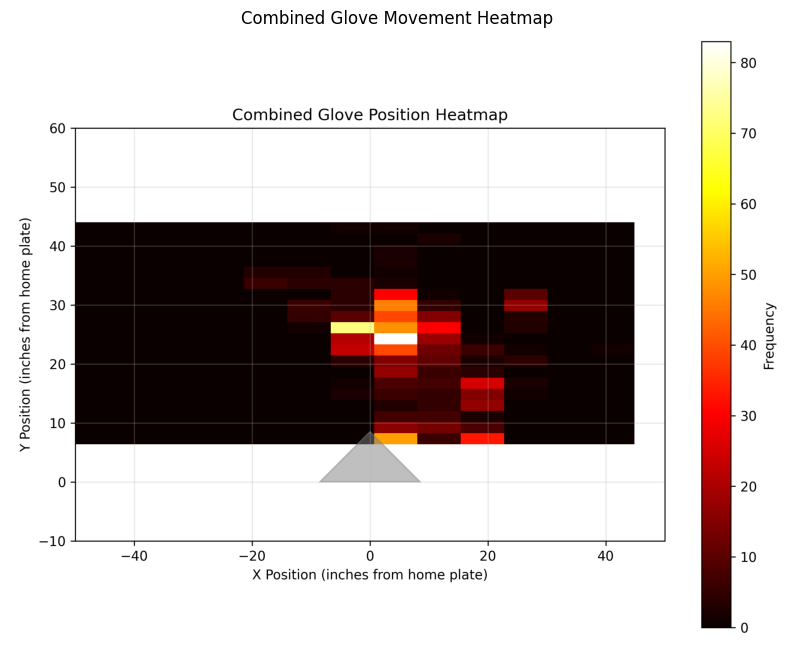


Batch Analysis Summary:


,video_filename,frame_count,frames_with_glove,frames_with_baseball,frames_with_homeplate,total_distance_inches,max_glove_movement_inches,avg_glove_movement_inches,glove_x_range_inches,glove_y_range_inches,avg_glove_x_position,avg_glove_y_position
0,WW-curveball.mp4,492,314,68,425,187.184785,16.899088,0.598034,26.714286,27.321429,9.690309,20.356301
1,test-fs.mp4,436,317,57,81,231.147795,40.657487,0.731480,43.250000,37.625000,9.989353,20.599369
2,test-sinker.mp4,376,258,53,319,391.988973,104.195806,1.525249,109.567073,32.756098,-1.613136,26.189852


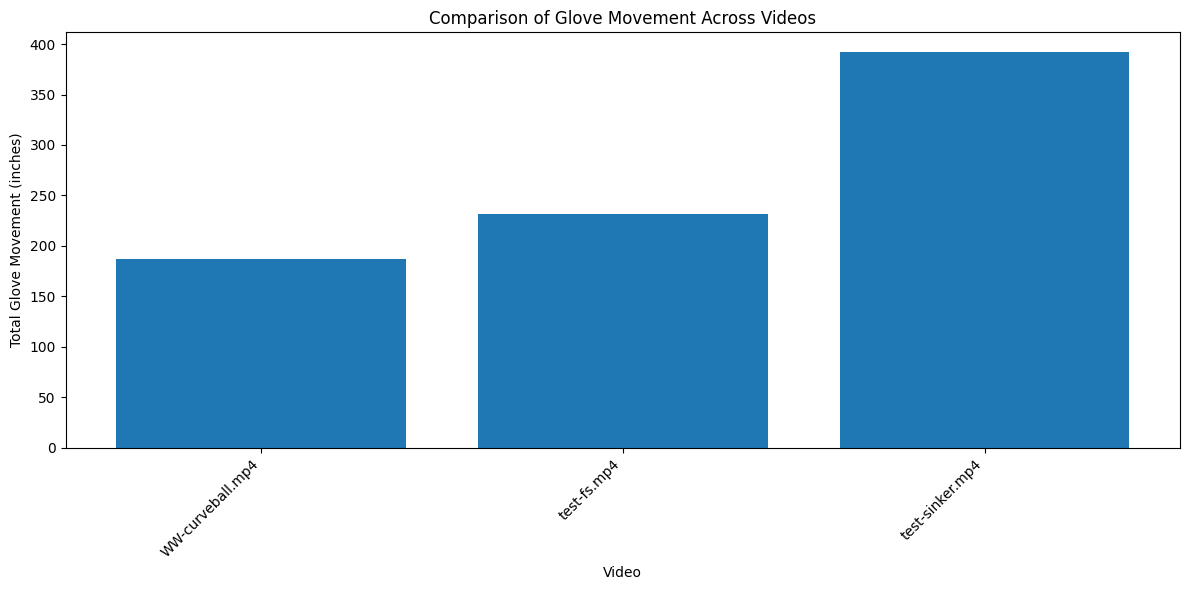

In [6]:
# Create a directory for batch processing
batch_dir = 'batch_videos'
os.makedirs(batch_dir, exist_ok=True)

# Upload multiple video files
print("\nPlease upload videos for batch analysis (you can select multiple files):")
uploaded = files.upload()
for filename in uploaded.keys():
    with open(os.path.join(batch_dir, filename), 'wb') as f:
        f.write(uploaded[filename])
    print(f"Saved {filename} to {batch_dir}")

# Show how many videos were uploaded
num_videos = len(glob.glob(os.path.join(batch_dir, "*.mp4")))
print(f"\nFound {num_videos} videos in the batch directory")

# Process videos in batch mode
batch_result = baseball_tools.track_gloves(
    mode="batch",                    # Process multiple videos
    input_folder=batch_dir,          # Folder containing videos
    delete_after_processing=False,   # Keep the original videos
    skip_confirmation=True,          # Skip deletion confirmation
    confidence_threshold=0.25,       # Minimum confidence for detections
    enable_filtering=True,           # Filter out physically impossible movements
    show_plot=True,                  # Include 2D tracking plot in output videos
    generate_heatmap=True,           # Generate heatmaps for each video and combined
    create_video=True,               # Create annotated output videos
    max_workers=1                    # Number of parallel workers (1 for sequential processing)
)

print(f"Processed {batch_result.get('processed_videos', 0)} videos")
print(f"Combined tracking data saved to: {batch_result.get('combined_csv', 'N/A')}")
print(f"Summary file saved to: {batch_result.get('summary_file', 'N/A')}")
print(f"Combined heatmap saved to: {batch_result.get('combined_heatmap', 'N/A')}")

# Display the combined heatmap if available
if 'combined_heatmap' in batch_result and batch_result['combined_heatmap']:
    try:
        combined_heatmap = cv2.imread(batch_result['combined_heatmap'])
        if combined_heatmap is not None:
            combined_heatmap_rgb = cv2.cvtColor(combined_heatmap, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(10, 8))
            plt.imshow(combined_heatmap_rgb)
            plt.axis('off')
            plt.title("Combined Glove Movement Heatmap")
            plt.show()
    except Exception as e:
        print(f"Note: Could not display combined heatmap: {e}")

# Analyze the batch summary data if available
if 'summary_file' in batch_result and batch_result['summary_file']:
    try:
        summary_df = pd.read_csv(batch_result['summary_file'])

        print("\nBatch Analysis Summary:")
        display(summary_df)

        # Create a bar chart comparing total distance across videos
        plt.figure(figsize=(12, 6))
        plt.bar(summary_df['video_filename'], summary_df['total_distance_inches'])
        plt.xlabel('Video')
        plt.ylabel('Total Glove Movement (inches)')
        plt.title('Comparison of Glove Movement Across Videos')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Unable to analyze summary data: {e}")

### Understanding batch processing:

Batch processing provides several advantages:

1. **Comparison**: Process multiple videos with the same parameters for consistent comparison.

2. **Combined Analysis**: Generates aggregate statistics and combined visualizations.

3. **Summary Data**: Creates a summary file with key metrics for each video:
   - Total glove movement distance
   - Range of motion
   - Average position
   - Maximum movement between frames

This is particularly useful for comparing different catchers, different pitch types, or the same catcher in different situations.

## 7. Advanced Usage: Video Scraping from Baseball Savant

BaseballCV can automatically download videos from Baseball Savant and process them. This is useful for analyzing MLB game footage:

In [ ]:
# Ask if the user wants to run the scraper
run_scrape = input("\nDo you want to run the scraper to download and analyze MLB videos? (y/n): ")
if run_scrape.lower() == 'y':
    # Process videos in scrape mode
    scrape_result = baseball_tools.track_gloves(
        mode="scrape",                  # Download and process MLB videos
        start_date="2024-04-01",        # Start date for video search
        end_date="2024-04-02",          # End date for video search
        team_abbr=None,                 # Optional: filter by team abbreviation (e.g., 'NYY')
        player=None,                    # Optional: filter by player ID
        pitch_type=None,                # Optional: filter by pitch type (e.g., 'FF' for four-seam fastball)
        max_videos=3,                   # Maximum number of videos to download
        max_videos_per_game=1,          # Maximum videos per game
        delete_after_processing=True,   # Delete downloaded videos after processing
        skip_confirmation=True,         # Skip deletion confirmation
        confidence_threshold=0.25,      # Minimum confidence for detections
        enable_filtering=True,          # Filter out physically impossible movements
        show_plot=True,                 # Include 2D tracking plot in output videos
        generate_heatmap=True,          # Generate heatmaps
        create_video=True,              # Create annotated output videos
        max_workers=2                   # Number of parallel workers
    )

    print(f"Processed {scrape_result.get('processed_videos', 0)} videos")
    print(f"Combined tracking data saved to: {scrape_result.get('combined_csv', 'N/A')}")
    print(f"Summary file saved to: {scrape_result.get('summary_file', 'N/A')}")
    print(f"Combined heatmap saved to: {scrape_result.get('combined_heatmap', 'N/A')}")

    # Display scrape-specific info
    if 'scrape_info' in scrape_result:
        print("\nScrape Information:")
        for key, value in scrape_result['scrape_info'].items():
            print(f"  {key}: {value}")

    # Analyze the scraped data if available
    if 'combined_csv' in scrape_result and os.path.exists(scrape_result['combined_csv']):
        try:
            combined_df = pd.read_csv(scrape_result['combined_csv'])

            # Extract Statcast data columns (they start with 'statcast_')
            statcast_columns = [col for col in combined_df.columns if col.startswith('statcast_')]

            if statcast_columns:
                print("\nStatcast data available in the tracking results:")
                display(combined_df[statcast_columns].head())

                # If pitch type data is available, analyze glove position by pitch type
                if 'statcast_pitch_type' in combined_df.columns:
                    pitch_groups = combined_df.groupby('statcast_pitch_type')

                    print("\nAverage glove position by pitch type:")
                    avg_positions = pitch_groups.agg({
                        'glove_real_x': 'mean',
                        'glove_real_y': 'mean'
                    })
                    display(avg_positions)

                    # Visualize average glove position by pitch type
                    plt.figure(figsize=(8, 8))
                    for pitch_type, group in pitch_groups:
                        if not pd.isna(pitch_type) and len(group) > 5:  # Only plot if we have enough data
                            plt.scatter(group['glove_real_x'].mean(),
                                      group['glove_real_y'].mean(),
                                      s=200,
                                      label=pitch_type)

                    # Draw home plate
                    home_plate_shape = np.array([[-8.5, 0], [8.5, 0], [0, 8.5], [-8.5, 0]])
                    plt.fill(home_plate_shape[:, 0], home_plate_shape[:, 1], color='gray', alpha=0.5)

                    plt.xlim(-30, 30)
                    plt.ylim(-5, 40)
                    plt.xlabel('X Position (inches from home plate)')
                    plt.ylabel('Y Position (inches from home plate)')
                    plt.title('Average Glove Position by Pitch Type')
                    plt.grid(True)
                    plt.legend()
                    plt.show()

        except Exception as e:
            print(f"Unable to analyze combined data: {e}")


Do you want to run the scraper to download and analyze MLB videos? (y/n): y
2025-04-11 22:09:52,693 - LoadTools - INFO - Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


INFO:LoadTools:Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


2025-04-11 22:09:53,241 - BaseballTools - INFO - Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


INFO:BaseballTools:Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


2025-04-11 22:09:53,242 - BaseballTools - INFO - Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


INFO:BaseballTools:Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


2025-04-11 22:10:17,169 - BaseballTools - INFO - Scraping videos from Baseball Savant...


INFO:BaseballTools:Scraping videos from Baseball Savant...

2025-04-11 22:10:18,720 - BaseballSavVideoScraper - INFO - Successfully downloaded video a9e284c2-90f5-4cf5-8fc0-4569e298f8c6


INFO:BaseballSavVideoScraper:Successfully downloaded video a9e284c2-90f5-4cf5-8fc0-4569e298f8c6


2025-04-11 22:10:19,194 - BaseballSavVideoScraper - INFO - Successfully downloaded video 89a91cab-2940-4887-9f05-016e5f15d638


INFO:BaseballSavVideoScraper:Successfully downloaded video 89a91cab-2940-4887-9f05-016e5f15d638

2025-04-11 22:10:19,237 - BaseballSavVideoScraper - INFO - Successfully downloaded video 6b471737-1f18-412e-8ce2-6ef639d6a7f5


INFO:BaseballSavVideoScraper:Successfully downloaded video 6b471737-1f18-412e-8ce2-6ef639d6a7f5

2025-04-11 22:10:19,243 - BaseballTools - INFO - Successfully scraped 3 videos



INFO:BaseballTools:Successfully scraped 3 videos


2025-04-11 22:10:19,245 - LoadTools - INFO - Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


INFO:LoadTools:Model found at models/od/YOLO/glove_tracking/model_weights/glove_tracking.pt


2025-04-11 22:10:19,420 - BaseballTools - INFO - Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


INFO:BaseballTools:Model loaded with classes: {0: 'glove', 1: 'homeplate', 2: 'baseball', 3: 'rubber'}


2025-04-11 22:10:19,421 - BaseballTools - INFO - Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


INFO:BaseballTools:Class IDs - Glove: 0, Home Plate: 1, Baseball: 2


2025-04-11 22:10:19,422 - BaseballTools - INFO - Found 3 videos to process in /tmp/savant_videos_zmjj5z6s


INFO:BaseballTools:Found 3 videos to process in /tmp/savant_videos_zmjj5z6s


2025-04-11 22:10:19,424 - BaseballTools - INFO - Processing videos in parallel with 2 workers


INFO:BaseballTools:Processing videos in parallel with 2 workers


Ultralytics 8.3.107 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


YOLO11x summary (fused): 190 layers, 56,831,644 parameters, 0 gradients, 194.4 GFLOPs
2025-04-11 22:10:50,738 - BaseballTools - INFO - Home plate reference set: 3.47 pixels per inch


INFO:BaseballTools:Home plate reference set: 3.47 pixels per inch


2025-04-11 22:10:50,747 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:10:50,897 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:27,551 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv with 366 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv with 366 frames


2025-04-11 22:12:27,554 - BaseballTools - INFO - Processed coordinates: 262 frames, Interpolated: 13 frames


INFO:BaseballTools:Processed coordinates: 262 frames, Interpolated: 13 frames


2025-04-11 22:12:27,557 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv


2025-04-11 22:12:27,560 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.mp4


2025-04-11 22:12:27,562 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:12:28,183 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.png


2025-04-11 22:12:28,188 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.png


2025-04-11 22:12:28,216 - BaseballTools - INFO - Deleted video: 745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.mp4


INFO:BaseballTools:Deleted video: 745109_6b471737-1f18-412e-8ce2-6ef639d6a7f5.mp4


2025-04-11 22:12:28,342 - BaseballTools - INFO - Home plate reference set: 3.94 pixels per inch


INFO:BaseballTools:Home plate reference set: 3.94 pixels per inch


2025-04-11 22:12:28,351 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:28,521 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:28,674 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:28,830 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:28,982 - BaseballTools - WARNING - No valid glove detection sequences found


2025-04-11 22:12:31,872 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv with 380 frames


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv with 380 frames


2025-04-11 22:12:31,878 - BaseballTools - INFO - Processed coordinates: 21 frames, Interpolated: 10 frames


INFO:BaseballTools:Processed coordinates: 21 frames, Interpolated: 10 frames


2025-04-11 22:12:31,881 - BaseballTools - INFO - CSV file saved successfully at glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv


INFO:BaseballTools:CSV file saved successfully at glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv


2025-04-11 22:12:31,884 - BaseballTools - INFO - Tracking completed. Output video saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638.mp4


INFO:BaseballTools:Tracking completed. Output video saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638.mp4


2025-04-11 22:12:31,887 - BaseballTools - INFO - Tracking data saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv


INFO:BaseballTools:Tracking data saved to glove_tracking_results/tracked_745844_89a91cab-2940-4887-9f05-016e5f15d638_tracking.csv
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.


2025-04-11 22:12:32,507 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_745844_89a91cab-2940-4887-9f05-016e5f15d638.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_745844_89a91cab-2940-4887-9f05-016e5f15d638.png


2025-04-11 22:12:32,511 - BaseballTools - INFO - Glove heatmap saved to glove_tracking_results/glove_heatmap_745844_89a91cab-2940-4887-9f05-016e5f15d638.png


INFO:BaseballTools:Glove heatmap saved to glove_tracking_results/glove_heatmap_745844_89a91cab-2940-4887-9f05-016e5f15d638.png


2025-04-11 22:12:32,535 - BaseballTools - INFO - Deleted video: 745844_89a91cab-2940-4887-9f05-016e5f15d638.mp4


INFO:BaseballTools:Deleted video: 745844_89a91cab-2940-4887-9f05-016e5f15d638.mp4


### Benefits of video scraping:

1. **MLB Data Integration**: The scraper automatically integrates Statcast pitch data with glove tracking, allowing for analysis by pitch type, velocity, etc.

2. **Broad Analysis**: Easily analyze multiple games, teams, or players without manually downloading videos.

3. **Research**: Facilitates research on MLB catcher techniques and patterns.

In this notebook, we've explored the capabilities of BaseballCV's GloveTracker for analyzing catcher glove movement and positioning. This technology enables detailed analysis of catcher technique, which can provide valuable insights for player development, scouting, and game strategy.

By processing videos with the GloveTracker, you can quantify aspects of catching that were previously only available through subjective observation. The resulting data and visualizations help coaches and players understand patterns and make data-driven improvements to technique and strategy.